In [1]:
# Load the Excel file
file_path = "All Data.xlsx"

=== Storm Damage Forecast Program ===

Available ISO codes (Countries):
- USA
- JAM
- JPN
- TUR
- IND
- CPV
- UGA
- GTM
- MMR
- MTQ
- VCT
- SUN
- CHN
- CAN
- COM
- ISR
- IRN
- NER
- BGD
- TWN
- GRC
- ITA
- PHL
- ALB
- COL
- CHL
- HKG
- ROU
- IDN
- FRA
- HTI
- MAR
- PRT
- PAK
- CRI
- DZA
- BFA
- GMB
- GNB
- MLI
- MRT
- SEN
- TCD
- KAZ
- MEX
- PER
- TKL
- PRI
- NZL
- AIA
- DFR
- ARG
- ECU
- BHS
- CUB
- EGY
- JOR
- BGR
- POL
- GLP
- MSR
- KNA
- BEL
- DOM
- NIC
- FJI
- BLZ
- HND
- SLB
- ARM
- TTO
- SLV
- NOR
- KOR
- PNG
- NCL
- GHA
- AUS
- VUT
- SDN
- ESP
- YMN
- COK
- YUG
- LBY
- TON
- AZO
- BMU
- REU
- BRA
- ATG
- VEN
- CHE
- GBR
- ZAF
- AUT
- NLD
- VNM
- CYP
- IRQ
- AFG
- ANT
- NPL
- BRB
- LBN
- MOZ
- MNG
- LKA
- TUN
- SPI
- PYF
- NIU
- LCA
- MUS
- ETH
- SOM
- THA
- GUM
- DMA
- GRD
- PRY
- SAU
- KEN
- TZA
- PAN
- WSM
- WLF
- MYS
- BOL
- BWA
- TGO
- COD
- LAO
- ASM
- URY
- MWI
- SYR
- COG
- MDG
- LSO
- SUR
- NGA
- BEN
- HUN
- CIV
- GUY
- CMR
- KIR
- TUV
- YMD
- ISL
- CAF
- CSK
- RWA
- SL

C:\Users\milan\AppData\Local\Temp\ipykernel_12860\939408721.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Year'] = filtered_data['DisNo.'].str[:4].astype(int)



Historical Damages (millions):
      Total Damage (Millions)
Year                         
1903                   480.00
1927                     0.23
1937                   438.00
1943                   900.00
1951                  1029.00
1964                   820.00
1969                   400.00
1972                   120.00
1973                   500.00
1976                    41.00
1977                   200.00
1980                   350.00
1982                    33.90
1983                   400.00
1984                    65.00
1985                    12.50
1986                    25.00
1990                    45.00
1991                   850.00
1993                 12290.00
1994                   700.00
1995                  3120.00
1996                  2720.00
1997                  7345.00
1998                  1062.00
1999                     0.30
2000                   286.00
2001                    33.00
2002                  1089.00
2003                   123.00
2004    

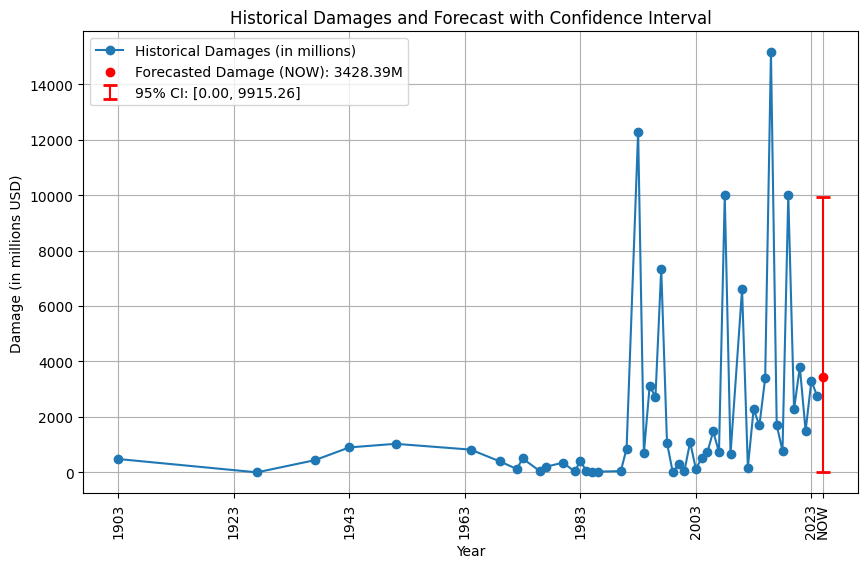

In [2]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import warnings
import matplotlib.pyplot as plt
import numpy as np

def load_data(file_path):
    try:
        return pd.read_excel(file_path)
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        return None

def forecast_damage(data, country, disaster_type):
    filtered_data = data[(data['ISO'] == country.upper()) & 
                         (data['Disaster Type'] == disaster_type)]

    if filtered_data.empty:
        return f"No historical data available for {disaster_type} in {country}.", None, None, None, None, None

    filtered_data['Year'] = filtered_data['DisNo.'].str[:4].astype(int)
    historical_data = filtered_data[['Year', 'Total Damage (\'000 US$)']].dropna()
    
    # Aggregate total damage per year
    historical_data = historical_data.groupby('Year')['Total Damage (\'000 US$)'].sum().reset_index()
    
    historical_data['Total Damage (Millions)'] = historical_data['Total Damage (\'000 US$)'] / 1_000
    historical_data.set_index('Year', inplace=True)

    # Augmented Dickey-Fuller test for unit roots
    adf_result = adfuller(historical_data['Total Damage (Millions)'].dropna())
    adf_pvalue = adf_result[1]

    # Fit ARIMA model
    warnings.filterwarnings("ignore")
    best_aic = float("inf")
    best_order = None
    best_model = None

    for p in range(0, 3):
        for d in range(0, 2):
            for q in range(0, 3):
                try:
                    model = ARIMA(historical_data['Total Damage (Millions)'], order=(p, d, q))
                    fitted_model = model.fit()
                    if fitted_model.aic < best_aic:
                        best_aic = fitted_model.aic
                        best_order = (p, d, q)
                        best_model = fitted_model
                except:
                    continue

    if best_model is None:
        return "ARIMA model fitting failed.", None, None, None, None, None

    # Forecast with 95% confidence interval (clipped at 0)
    forecast = best_model.get_forecast(steps=1)
    forecast_mean = forecast.predicted_mean.iloc[0]
    conf_int = forecast.conf_int().iloc[0].tolist()  # [lower, upper]
    
    # Ensure confidence interval does not go below 0
    conf_int[0] = max(conf_int[0], 0)  # Clip lower bound at 0

    return (
        round(forecast_mean, 2), 
        historical_data, 
        best_order, 
        round(best_aic, 2), 
        round(adf_pvalue, 3),
        conf_int
    )

def plot_forecast(historical_data, forecasted_value, conf_interval):
    next_year = historical_data.index[-1] + 1

    plt.figure(figsize=(10, 6))
    plt.plot(historical_data.index, historical_data['Total Damage (Millions)'], 
             label="Historical Damages (in millions)", marker='o')

    # Plot forecasted value with confidence interval
    plt.scatter(next_year, forecasted_value, color='red', zorder=5,
                label=f"Forecasted Damage (NOW): {forecasted_value}M")
    plt.errorbar(next_year, forecasted_value, 
                 yerr=[[forecasted_value - conf_interval[0]], [conf_interval[1] - forecasted_value]], 
                 fmt='none', ecolor='red', capsize=5, capthick=2,
                 label=f"95% CI: [{conf_interval[0]:.2f}, {conf_interval[1]:.2f}]")

    plt.title("Historical Damages and Forecast with Confidence Interval")
    plt.xlabel("Year")
    plt.ylabel("Damage (in millions USD)")
    plt.legend()
    plt.grid()

    year_ticks = list(range(historical_data.index.min(), historical_data.index.max() + 1, 20)) + [next_year]
    year_labels = [str(year) for year in year_ticks[:-1]] + ['NOW']
    plt.xticks(year_ticks, labels=year_labels, rotation=90)
    plt.show()

if __name__ == "__main__":
    print("=== Storm Damage Forecast Program ===")
    file_path = "All Data.xlsx"
    data = load_data(file_path)

    if data is not None:
        unique_iso_codes = data['ISO'].dropna().unique()
        print("\nAvailable ISO codes (Countries):")
        for iso_code in unique_iso_codes:
            print(f"- {iso_code}")

        user_country = input("\nEnter the country (ISO code, e.g., 'USA'): ").strip().upper()
        available_disasters = data[data['ISO'] == user_country]['Disaster Type'].dropna().unique()

        if not available_disasters.size:
            print(f"No disaster data for {user_country}.")
        else:
            print(f"\nAvailable disaster types for {user_country}:")
            for disaster_type in available_disasters:
                print(f"- {disaster_type}")

            user_disaster_type = input("\nEnter the disaster type (e.g., 'Storm'): ").strip()
            result, historical_data, arima_order, aic_value, adf_pvalue, conf_interval = forecast_damage(
                data, user_country, user_disaster_type
            )

            if isinstance(result, float):
                print(f"\nHistorical Damages (millions):")
                print(historical_data[['Total Damage (Millions)']])
                print(f"\nForecast for {historical_data.index[-1] + 1}: {result}M USD")
                print(f"95% Confidence Interval: [{conf_interval[0]:.2f}, {conf_interval[1]:.2f}]")
                print(f"ARIMA Order: {arima_order}")
                print(f"AIC: {aic_value}")
                print(f"ADF p-value: {adf_pvalue} (p < 0.05 ⇒ stationary)")
                plot_forecast(historical_data, result, conf_interval)
            else:
                print(result)
    else:
        print("Failed to load data.")